In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))
sys.path.append(os.path.abspath("../backend"))
sys.path.append(os.path.abspath(""))

In [3]:
from owlready2 import *
from rdflib import Graph, URIRef, Literal
from rdflib.plugins.sparql import prepareQuery
import networkx as nx

In [4]:
from backend.ontology import *

In [5]:
base_path = "../data"
onto_path = base_path + "/hero-ontology/hereditary_clinical.ttl"

In [6]:
brainteaser_graph = Graph().parse(onto_path, format="turtle")
brainteaser_graph.bind("bto", "http://www.semanticweb.org/ontologies/2020/3/bto#")

In [7]:
oman = OntologyManager(OntologyConfig(), brainteaser_graph)

In [8]:
root_classes = oman.load_full_graph()

enriching <http://ontology.eil.utoronto.ca/GCI/Environment/Pollution.owl#Air_pollution_concentration>
enriching <https://w3id.org/brainteaser/ontology/schema/C6H6_concentration>
enriching <https://w3id.org/brainteaser/ontology/schema/CO_concentration>
enriching <http://purl.oclc.org/NET/ssnx/ssn#SensingDevice>
enriching <http://www.w3.org/2000/10/swap/pim/contact#Person>
enriching <https://w3id.org/brainteaser/ontology/schema/Patient>
enriching <https://orcid.org/0000-0001-9219-6239>
enriching <https://orcid.org/0000-0001-9709-6392>
enriching <https://orcid.org/0000-0002-0676-682X>
enriching <https://orcid.org/0000-0002-5070-2049>
enriching <https://orcid.org/0000-0003-0362-5893>
enriching <https://orcid.org/0000-0003-4970-4554>
enriching time:Instant
enriching <http://www.wurvoc.org/vocabularies/om-1.8/Unit_of_measure>
enriching <https://w3id.org/brainteaser/ontology/schema/Activity>
enriching <https://w3id.org/brainteaser/ontology/schema/Lifestyle>
enriching <https://w3id.org/brainte

In [9]:
root_classes[1]

Subject(subject_id='<http://purl.oclc.org/NET/ssnx/ssn#SensingDevice>', label='<http://purl.oclc.org/NET/ssnx/ssn#SensingDevice>', spos={'rdf:type': ['owl:Class']}, subject_type='class', refcount=0, descendants={'subClass': [], 'namedIndividual': []}, total_descendants=1, properties={'ObjectProperty': [Subject(subject_id='<https://w3id.org/brainteaser/ontology/schema/coveredPlace>', label='coveredPlace', spos={'rdf:type': ['owl:ObjectProperty'], 'rdfs:domain': ['<http://purl.oclc.org/NET/ssnx/ssn#SensingDevice>'], 'rdfs:range': ['<https://w3id.org/brainteaser/ontology/schema/Place>'], 'rdfs:comment': ['It defines the relationship between the sensing device for environmental data and the covered place.'], 'rdfs:label': ['coveredPlace']}, subject_type='individual', refcount=0, descendants={}, total_descendants=0, properties={})], 'DatatypeProperty': []})

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from glob import glob
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [11]:
onto_relations: list[tuple[list[str], str]] = []


def get_relations(subj: Subject, path: list[str] = []):
    for prop_typ, props in subj.properties.items():
        for prop in props:
            onto_relations.append((path + [subj.label, prop.label], prop.subject_id))

    for desc_typ, descs in subj.descendants.items():
        for desc in descs:
            if desc.subject_type != subj.subject_type:
                onto_relations.append(
                    (
                        path + [subj.label, desc.label],
                        desc.subject_id,
                    )
                )
            else:
                get_relations(desc, path=path + [subj.label])


[get_relations(root) for root in root_classes]
all_relations = pd.DataFrame(range(len(onto_relations)), columns=["id"])
all_relations["p_s"] = onto_relations
all_relations["path"] = all_relations["p_s"].map(lambda x: x[0])
all_relations["subject_id"] = all_relations["p_s"].map(lambda x: x[1])
all_relations["text"] = all_relations["path"].map(lambda x: " ".join(x))
all_relations.to_csv("all_relations.csv", index=False)

In [12]:
all_relations

,id,p_s,path,subject_id,text
0,0,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://purl.oclc.org/NET/ssnx/ssn#isProducedBy>,<http://ontology.eil.utoronto.ca/GCI/Environme...
1,1,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://www.wurvoc.org/vocabularies/om-1.8/uni...,<http://ontology.eil.utoronto.ca/GCI/Environme...
2,2,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...
3,3,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...
4,4,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...
...,...,...,...,...,...
894,894,"([Therapeutic Treatment, administration], <htt...","[Therapeutic Treatment, administration]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment administration
895,895,"([Therapeutic Treatment, pharmacologicSubstanc...","[Therapeutic Treatment, pharmacologicSubstance]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment pharmacologicSubstance
896,896,"([Therapeutic Treatment, therapyType], <https:...","[Therapeutic Treatment, therapyType]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment therapyType
897,897,"([Trauma, traumaDate], <https://w3id.org/brain...","[Trauma, traumaDate]",<https://w3id.org/brainteaser/ontology/schema/...,Trauma traumaDate


In [13]:
encoding = model.encode(all_relations["text"].values)
all_relations["embeddings"] = [encoding[e, :] for e in range(encoding.shape[0])]

In [ ]:
tfidf_array = vectorizer.fit_transform(all_relations["text"]).toarray()
all_relations["tfidf"] = [tfidf_array[e, :] for e in range(tfidf_array.shape[0])]

In [15]:
all_relations

,id,p_s,path,subject_id,text,embeddings,tfidf
0,0,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://purl.oclc.org/NET/ssnx/ssn#isProducedBy>,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.08878864, -0.02191236, 0.00569469, 0.004866...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://www.wurvoc.org/vocabularies/om-1.8/uni...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.08203993, -0.039499164, -0.006548445, 0.000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.0806465, -0.05137669, 0.0071671535, -0.0004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.11070274, -0.025878323, 0.022785362, -0.012...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.09448482, -0.022643195, 8.139194e-05, 0.018...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
894,894,"([Therapeutic Treatment, administration], <htt...","[Therapeutic Treatment, administration]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment administration,"[-0.008879084, 0.00890982, -0.007270886, 0.054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
895,895,"([Therapeutic Treatment, pharmacologicSubstanc...","[Therapeutic Treatment, pharmacologicSubstance]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment pharmacologicSubstance,"[-0.013776337, -0.019011427, -0.014824607, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
896,896,"([Therapeutic Treatment, therapyType], <https:...","[Therapeutic Treatment, therapyType]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment therapyType,"[-0.013458574, -0.017691838, 0.009163428, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
897,897,"([Trauma, traumaDate], <https://w3id.org/brain...","[Trauma, traumaDate]",<https://w3id.org/brainteaser/ontology/schema/...,Trauma traumaDate,"[-0.012793325, 0.056337398, 0.049347922, 0.087...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
os.getcwd()

'/Users/benedikt/tugraz/cgv/hereditary/ontology_provenance/exploration'

In [17]:
all_csvs = glob("../data/**/*.csv", recursive=True)
all_csvs

['../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/test/test_environmental_meas.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/test/test_outcome.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/test/test_edss.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/test/test_static.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/train/train_environmental_meas.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/train/train_edss.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/train/train_outcome.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/MS/CSV/data/train/train_static.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/ALS/CSV/data/Task1/test/test-alsfrs.csv',
 '../data/datasets/BRAINTEASER_ALS_MS_datasets/prospective/ALS/CSV/data/Task1/test/test-target.csv',
 '../data/datase

In [18]:
import regex as re


def make_readable(txt: str, split_chars=["_", "-", "/", ":", "."]):
    if txt is None:
        return ""
    txt = re.sub(r"([a-z])([A-Z])", r"\1 \2", txt)
    txt = re.sub(r"([A-Z])([A-Z][a-z])", r"\1 \2", txt)
    txt = re.sub(r"([a-z])([0-9])", r"\1 \2", txt)
    txt = re.sub(r"([0-9])([a-z])", r"\1 \2", txt)
    for split_char in split_chars:
        txt = " ".join(txt.split(split_char))
    return txt

In [19]:
class DataSetRepresentation:
    def __init__(self, path: str, index_col: str | int = 0):
        self.paths = [path]
        self.df = pd.read_csv(path, index_col=index_col)
        if self.df.shape[1] == 0:
            self.df = pd.read_csv(path, index_col=index_col, sep=";")
        self.columns = self.df.columns.tolist()
        self.columns_embedding: list[np.ndarray] = None

    def expand_categorical(self):
        self.unique_counts = self.df.nunique()
        self.categorical_columns = self.df.columns[
            (self.unique_counts / len(self.df) < 0.3)
            & (self.unique_counts > 1)
            & (self.unique_counts < 512)
            & (self.df.dtypes == "object")
        ].to_list()
        self.df = pd.get_dummies(self.df, columns=self.categorical_columns)

    def merge(self, other: "DataSetRepresentation"):
        if other.df.shape[1] > 0:
            self.df = pd.concat([self.df, other.df])
        self.columns = self.df.columns
        self.paths.append(other.paths)

    def col_id(self):
        return ",".join(self.df.columns.tolist())

    def cols_readable(self):
        index_name = self.df.index.name
        col_names_flipped = [
            f"{make_readable(col)} {make_readable( index_name )} {make_readable(self.paths[0])}"
            for col in self.df.columns
        ]
        return col_names_flipped

    def embed_cols(self):
        columns_embedding = model.encode(self.cols_readable())
        self.columns_embedding = [
            columns_embedding[e, :] for e in range(columns_embedding.shape[0])
        ]
        return self.columns_embedding

    def tfidf_cols(self):
        columns_tfidf = vectorizer.transform(self.cols_readable()).toarray()
        self.columns_tfidf = [
            columns_tfidf[e, :] for e in range(columns_tfidf.shape[0])
        ]
        return self.columns_tfidf


representations = [DataSetRepresentation(csv) for csv in all_csvs]

In [20]:
mergeables: dict[str, list[DataSetRepresentation]] = {}
for rep in representations:
    if rep.col_id() not in mergeables:
        mergeables[rep.col_id()] = []
    mergeables[rep.col_id()].append(rep)
for k, mergeable in mergeables.items():
    print(k, len(mergeable))

week_from_baseline,PM25_num,PM25_mean,PM25_who,PM10_num,PM10_mean,PM10_who,CO_num,CO_mean,CO_who,NO2_num,NO2_mean,NO2_who,O3_num,O3_mean,O3_who,SO2_num,SO2_mean,SO2_who,wind_speed_num,wind_speed_mean,humidity_num,humidity_mean,sealevel_pressure_num,sealevel_pressure_mean,global_radiation_num,global_radiation_mean,precipitation_num,precipitation_mean,average_temperature_num,average_temperature_mean,min_temperature_num,min_temperature_mean,max_temperature_num,max_temperature_mean 2
week_from_baseline 2
pyramidal,cerebellar,brainstem,sensory,bowel_and_bladder,visual_function,cerebral_functions,ambulation,edss_as_evaluated_by_clinician,week_from_baseline 2
sex,residence_classification,ethnicity,ms_in_pediatric_age,age_at_onset,age_at_baseline,diagnostic_delay,diagnosis_criteria_detail,spinal_cord_symptom,brainstem_symptom,eye_symptom,supratentorial_symptom,other_symptoms,centre,diagnosis_criteria 2
Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,first_alsfrs_days_from_diagnosis,target_alsfrs_days_f

In [21]:
for col_id, reps in mergeables.items():
    if len(reps) > 1:
        for rep in reps[1:]:
            reps[0].merge(rep)
        mergeables[col_id] = reps[:1]
representations_merged = [rep for reps in mergeables.values() for rep in reps]

/var/folders/w0/5b7f2srd2sb_56zjv17vqnym0000gn/T/ipykernel_8895/1739516065.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.df = pd.concat([self.df, other.df])


In [22]:
for rep in representations_merged:
    print(rep.df.shape)

(160277, 35)
(280, 1)
(1124, 10)
(280, 15)
(40, 14)
(40, 12)
(36584, 91)
(144, 6)
(490, 14)
(1250, 2)
(774, 3)
(7214, 3)
(1188, 13)
(1188, 2)
(3306, 5)
(2424, 10)
(6081, 3)
(6081, 97)
(20508, 19)
(11661330, 4)
(2513, 1)
(1112228, 13)
(2504, 1)
(150, 3)
(6081, 4)
(6081, 98)
(20508, 20)
(11661330, 5)


In [23]:
for rep in representations_merged:
    print(rep.df.shape)
    rep.expand_categorical()

(160277, 35)
(280, 1)
(1124, 10)
(280, 15)
(40, 14)
(40, 12)
(36584, 91)
(144, 6)
(490, 14)
(1250, 2)
(774, 3)
(7214, 3)
(1188, 13)
(1188, 2)
(3306, 5)
(2424, 10)
(6081, 3)
(6081, 97)
(20508, 19)
(11661330, 4)
(2513, 1)
(1112228, 13)
(2504, 1)
(150, 3)
(6081, 4)
(6081, 98)
(20508, 20)
(11661330, 5)


In [24]:
for rep in representations_merged:
    rep.embed_cols()
    rep.tfidf_cols()

In [25]:
rep.df.index.name

'PatientID'

## Ontology assignment algorithm
* rank best matching columns
* greedily pick the best columns
* move on to lower cols

In [26]:
import tqdm

In [27]:
all_relations["rankings"] = all_relations["embeddings"].map(lambda x: {})
for i, relation in tqdm.tqdm(all_relations.iterrows(), total=all_relations.shape[0]):
    relation_embedding = relation["embeddings"]
    best_match = None
    best_match_score = 0
    rankings = []
    for r_idx, rep in enumerate(representations_merged):
        readable_col_names = rep.cols_readable()
        col_similarities = np.dot(relation_embedding, np.array(rep.columns_embedding).T)
        rankings.extend(
            [
                (
                    f"{r_idx}-{i}",
                    col_similarities[i],
                )
                for i in range(len(col_similarities))
            ]
        )
    ranking_sorted = pd.DataFrame(rankings, columns=["idx", "score"]).sort_values(
        "score", ascending=False
    )

    all_relations.at[i, "rankings"] = ranking_sorted

100%|██████████| 899/899 [01:06<00:00, 13.49it/s]


In [28]:
all_relations

,id,p_s,path,subject_id,text,embeddings,tfidf,rankings
0,0,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://purl.oclc.org/NET/ssnx/ssn#isProducedBy>,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.08878864, -0.02191236, 0.00569469, 0.004866...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 22 0-22 0.228521 20 ...
1,1,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<http://www.wurvoc.org/vocabularies/om-1.8/uni...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.08203993, -0.039499164, -0.006548445, 0.000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 22 0-22 0.282241 806 ...
2,2,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.0806465, -0.05137669, 0.0071671535, -0.0004...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 22 0-22 0.250539 20 ...
3,3,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.11070274, -0.025878323, 0.022785362, -0.012...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 22 0-22 0.259577 21 ...
4,4,([<http://ontology.eil.utoronto.ca/GCI/Environ...,[<http://ontology.eil.utoronto.ca/GCI/Environm...,<https://w3id.org/brainteaser/ontology/schema/...,<http://ontology.eil.utoronto.ca/GCI/Environme...,"[0.09448482, -0.022643195, 8.139194e-05, 0.018...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 22 0-22 0.264110 20 ...
...,...,...,...,...,...,...,...,...
894,894,"([Therapeutic Treatment, administration], <htt...","[Therapeutic Treatment, administration]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment administration,"[-0.008879084, 0.00890982, -0.007270886, 0.054...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 213 9-0 0.251511 21...
895,895,"([Therapeutic Treatment, pharmacologicSubstanc...","[Therapeutic Treatment, pharmacologicSubstance]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment pharmacologicSubstance,"[-0.013776337, -0.019011427, -0.014824607, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 213 9-0 0.168086 31...
896,896,"([Therapeutic Treatment, therapyType], <https:...","[Therapeutic Treatment, therapyType]",<https://w3id.org/brainteaser/ontology/schema/...,Therapeutic Treatment therapyType,"[-0.013458574, -0.017691838, 0.009163428, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 291 16-5 0.230976 21...
897,897,"([Trauma, traumaDate], <https://w3id.org/brain...","[Trauma, traumaDate]",<https://w3id.org/brainteaser/ontology/schema/...,Trauma traumaDate,"[-0.012793325, 0.056337398, 0.049347922, 0.087...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",idx score 777 25-200 0.523399 77...


In [29]:
all_relations["rankings_moving"] = all_relations["rankings"].copy()


def update_df_best_match(rels: pd.DataFrame):
    all_relations["best_match"] = all_relations["rankings_moving"].map(
        lambda x: x.iloc[0]
    )
    rels["best_match_colname"] = rels["best_match"].map(
        lambda x: representations_merged[int(x["idx"].split("-")[0])].df.columns[
            int(x["idx"].split("-")[1])
        ]
    )
    rels["best_match_score"] = rels["best_match"].map(lambda x: x["score"])
    rels["best_match_idx"] = rels["best_match"].map(lambda x: x["idx"])
    return rels

still_non_unique = True
last_uniques = 0
while still_non_unique:
    all_relations = update_df_best_match(all_relations)
    uniques = all_relations["best_match_idx"].unique()
    print(len(uniques), all_relations[all_relations["best_match_idx"].notna()].shape[0])
    if len(uniques) == last_uniques:
        still_non_unique = False
    last_uniques = len(uniques)
    for unique_idx in uniques:
        selection = all_relations[all_relations["best_match_idx"] == unique_idx]
        if selection.shape[0] > 1:
            # used more than once - only keep highest scoring, move others to second
            sorted_selection = selection.sort_values(
                "best_match_score", ascending=False
            )
            following_idx = sorted_selection.index[1:]
            all_relations.loc[following_idx, "rankings_moving"] = all_relations.loc[
                following_idx, "rankings_moving"
            ].map(lambda x: x[1:])
            all_relations = update_df_best_match(all_relations)

277 899
393 899
449 899
491 899
516 899
541 899
558 899
574 899
585 899
597 899
605 899
611 899
621 899
627 899
633 899
642 899
649 899
654 899
662 899
670 899
673 899
677 899
679 899
684 899
689 899
689 899


In [30]:
all_relations["best_match_score"]

0      0.186378
1      0.282241
2      0.227295
3      0.241396
4      0.250989
         ...   
894    0.180481
895    0.090074
896    0.217167
897    0.523399
898    0.494089
Name: best_match_score, Length: 899, dtype: float32

<Axes: xlabel='best_match_score', ylabel='Count'>

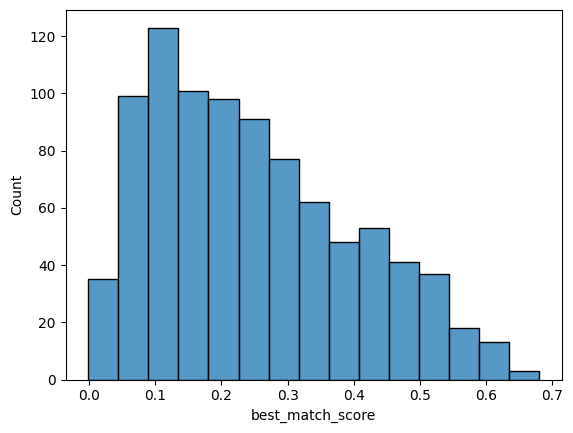

In [31]:
import seaborn as sns

sns.histplot(all_relations, x="best_match_score")

In [39]:
all_relations_filtered = all_relations.copy()
all_relations_filtered_selection = all_relations_filtered[
    all_relations_filtered["best_match_score"] < 0.15
]
all_relations_filtered.loc[
    all_relations_filtered_selection.index, "best_match_colname"
] = None
all_relations_filtered.loc[
    all_relations_filtered_selection.index, "best_match_score"
] = None
all_relations_filtered.loc[all_relations_filtered_selection.index, "best_match_idx"] = (
    None
)

In [ ]:
all_relations_matches = all_relations_filtered[
    [
        "path",
        "subject_id",
        "text",
        "best_match_colname",
        "best_match_score",
        "best_match_idx",
    ]
]
all_relations_matches.to_csv("all_relations_best_match.csv", index=False)

In [77]:
target_id = "<http://data.europa.eu/esco/isco/C0>"

match = all_relations_filtered[all_relations_filtered["subject_id"] == target_id].iloc[
    0
]
match

id                                                                  468
p_s                   ([Occupation, Armed forces occupations], <http...
path                             [Occupation, Armed forces occupations]
subject_id                         <http://data.europa.eu/esco/isco/C0>
text                                Occupation Armed forces occupations
embeddings            [0.016311552, -0.016082877, 0.039316628, 0.037...
tfidf                 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
rankings                      idx     score
695  25-118  0.478041
41...
rankings_moving               idx     score
410  17-118  0.438708
72...
best_match            idx        17-118
score    0.438708
Name: 410,...
best_match_colname      occupation_Armed_forces_occupations_other_ranks
best_match_score                                               0.438708
best_match_idx                                                   17-118
Name: 468, dtype: object

In [ ]:
def unwrap_idx(idx: str):
    return int(idx.split("-")[0]), int(idx.split("-")[1])


repr_idx, col_idx = unwrap_idx(match["best_match_idx"])

repr = representations_merged[repr_idx]
col_name = repr.df.columns[col_idx]

In [86]:
def is_postive(series: pd.Series):  # TODO improve positive check?
    if series.dtype == "bool":
        return series
    elif series.dtype == "object":
        return series.notnull() & (series != "")
    else:
        return series.notna() & (series > 0)


class Match(BaseModel):
    colname: str
    idx: str
    score: float


class RelationsFound(BaseModel):
    path: list[str]
    subject_id: str
    text: str
    matches: list[Match] = []
    best_match: Match


class SparseLinks(BaseModel):
    source: RelationsFound
    target: RelationsFound
    count: int


def relation_row_to_relation_found(row: pd.Series, repr: DataSetRepresentation, top_k=5):
    matches = []
    repr_idx, col_idx = unwrap_idx(row["best_match_idx"])
    for idx, match in row["rankings"].iloc[:top_k].iterrows():

        m_repr_idx, m_col_idx = unwrap_idx(match["idx"])
        m_repr = representations_merged[m_repr_idx]
        matches.append(
            Match(
                colname=m_repr.df.columns[m_col_idx],
                idx=match["idx"],
                score=match["score"],
            )
        )
    best_match = Match(
        colname=repr.df.columns[col_idx],
        idx=row["best_match_idx"],
        score=row["best_match_score"],
    )
    return RelationsFound(
        path=row["path"],
        subject_id=row["subject_id"],
        text=row["text"],
        matches=matches,
        best_match=best_match,
    )


links: list[SparseLinks] = []
positive_instances = repr.df[is_postive(repr.df.iloc[:, col_idx])]

for other_idx, other_col in enumerate(positive_instances.columns.to_list()):
    identifier = f"{repr_idx}-{other_idx}"
    if other_idx == col_idx:
        continue  # skip self
    if identifier in all_relations_filtered["best_match_idx"].values:
        positive_count = positive_instances[
            is_postive(positive_instances.iloc[:, other_idx])
        ].shape[0]
        if positive_count > 0:
            col_matches = all_relations_filtered[
                all_relations_filtered["best_match_idx"] == identifier
            ]
            for other_match_idx, other_match in col_matches.iterrows():
                links.append(
                    SparseLinks(
                        source=relation_row_to_relation_found(match, repr=repr),
                        target=relation_row_to_relation_found(other_match, repr=repr),
                        count=positive_count,
                    )
                )
links

[SparseLinks(source=RelationsFound(path=['Intervention or Procedure', 'Diagnostic Procedure', 'Clinical Evaluation', 'weight'], subject_id='<https://w3id.org/brainteaser/ontology/schema/weight>', text='Intervention or Procedure Diagnostic Procedure Clinical Evaluation weight', matches=[Match(colname='weight_before_onset', idx='17-4', score=0.3991459012031555), Match(colname='weight_before_onset', idx='25-4', score=0.3933265209197998), Match(colname='moreThan10PercentWeightloss_True', idx='17-76', score=0.39076679944992065), Match(colname='moreThan10PercentWeightloss_False', idx='17-75', score=0.3880930542945862), Match(colname='moreThan10PercentWeightloss_True', idx='25-76', score=0.3849042057991028)], best_match=Match(colname='weight_before_onset', idx='17-4', score=0.3991459012031555)), target=RelationsFound(path=['Intervention or Procedure', 'Diagnostic Procedure', 'Clinical Evaluation', 'weight'], subject_id='<https://w3id.org/brainteaser/ontology/schema/weight>', text='Interventio

In [76]:
len(links)

47

In [66]:
[l for l in positive_instances.columns.to_list() if l == other_col]

['SOD1 mutation_False', 'SOD1 mutation_False']

In [53]:
is_postive(positive_instances, other_col)

,SOD1 mutation_False,SOD1 mutation_False
PatientID,,
0xacb436d25d0d3285573a7a4b589b9b9b,False,True
0xbcc7dd9be6408d6686a538bb6baa9fdd,False,False
0xc71dc7aa406ebd9fda73c3a3c704f1b7,False,False
0xedbd9bc377e62cb50bf2d3357144ea5c,True,False
0xf25577a5c837f2571b84329ad66e0141,True,False
0x975ec7581c31bcdb0440450f1a2614e,False,False
0xacb436d25d0d3285573a7a4b589b9b9b,False,True
0xbcc7dd9be6408d6686a538bb6baa9fdd,False,False
0xc71dc7aa406ebd9fda73c3a3c704f1b7,False,False
